### Libraries

In [1]:
import sys
!{sys.executable} -m pip install quandl hmmlearn
import json

  Using cached Quandl-3.5.0-py2.py3-none-any.whl (25 kB)
     |████████████████████████████████| 363 kB 24.7 MB/s eta 0:00:01
  Using cached inflection-0.5.0-py2.py3-none-any.whl (5.8 kB)


In [2]:
import os
print(os.getcwd())
with open('../config/iex.conf') as fJsn:
    jsnIEX = json.load(fJsn)


/home/notebooks


In [4]:
import quandl
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy import stats
from matplotlib import cm, pyplot as plt
from hmmlearn.hmm import GaussianHMM
import scipy
import datetime
import json
import seaborn as sns
#from sklearn.externals import joblib

sns.set()

### Basic functions for the analysis
Modelling, feature engineering, plotting.

In [5]:
import warnings
warnings.filterwarnings("ignore")

# Brute force modelling
def get_best_hmm_model(X, max_states, max_iter = 10000):
    best_score = -(10 ** 10)
    best_state = 0
    
    for state in range(1, max_states + 1):
        hmm_model = GaussianHMM(n_components = state, random_state = 100,
                                covariance_type = "diag", n_iter = max_iter).fit(X)
        if hmm_model.score(X) > best_score:
            best_score = hmm_model.score(X)
            best_state = state
    
    best_model = GaussianHMM(n_components = best_state, random_state = 100,
                                covariance_type = "diag", n_iter = max_iter).fit(X)
    return best_model

# Normalized st. deviation
def std_normalized(vals):
    return np.std(vals) / np.mean(vals)

# Ratio of diff between last price and mean value to last price
def ma_ratio(vals):
    return (vals[-1] - np.mean(vals)) / vals[-1]

# z-score for volumes and price
def values_deviation(vals):
    return (vals[-1] - np.mean(vals)) / np.std(vals)

# General plots of hidden states
def plot_hidden_states(hmm_model, data, X, column_price):
    plt.figure(figsize=(15, 15))
    fig, axs = plt.subplots(hmm_model.n_components, 3, figsize = (15, 15))
    colours = cm.prism(np.linspace(0, 1, hmm_model.n_components))
    hidden_states = hmm_model.predict(X)
    
    for i, (ax, colour) in enumerate(zip(axs, colours)):
        mask = hidden_states == i
        ax[0].plot(data.index, data[column_price], c = 'grey')
        ax[0].plot(data.index[mask], data[column_price][mask], '.', c = colour)
        ax[0].set_title("{0}th hidden state".format(i))
        ax[0].grid(True)
        
        ax[1].hist(data["future_return"][mask], bins = 30)
        ax[1].set_xlim([-0.1, 0.1])
        ax[1].set_title("future return distrbution at {0}th hidden state".format(i))
        ax[1].grid(True)
        
        ax[2].plot(data["future_return"][mask].cumsum(), c = colour)
        ax[2].set_title("cummulative future return at {0}th hidden state".format(i))
        ax[2].grid(True)
        
    plt.tight_layout()

def mean_confidence_interval(vals, confidence):
    a = 1.0 * np.array(vals)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m - h, m, m + h

def compare_hidden_states(hmm_model, cols_features, conf_interval, iters = 1000):
    plt.figure(figsize=(15, 15))
    fig, axs = plt.subplots(len(cols_features), hmm_model.n_components, figsize = (15, 15))
    colours = cm.prism(np.linspace(0, 1, hmm_model.n_components))
    
    for i in range(0, hmm_model.n_components):
        mc_df = pd.DataFrame()
    
        # Samples generation
        for j in range(0, iters):
            row = np.transpose(hmm_model._generate_sample_from_state(i))
            mc_df = mc_df.append(pd.DataFrame(row).T)
        mc_df.columns = cols_features
    
        for k in range(0, len(mc_df.columns)):
            axs[k][i].hist(mc_df[cols_features[k]], color = colours[i])
            axs[k][i].set_title(cols_features[k] + " (state " + str(i) + "): " + str(np.round(mean_confidence_interval(mc_df[cols_features[k]], conf_interval), 3)))
            axs[k][i].grid(True)
            
    plt.tight_layout()

### Downloading data and plot

Index(['High', 'Low', 'Mid', 'Last', 'Bid', 'Ask', 'Volume'], dtype='object')


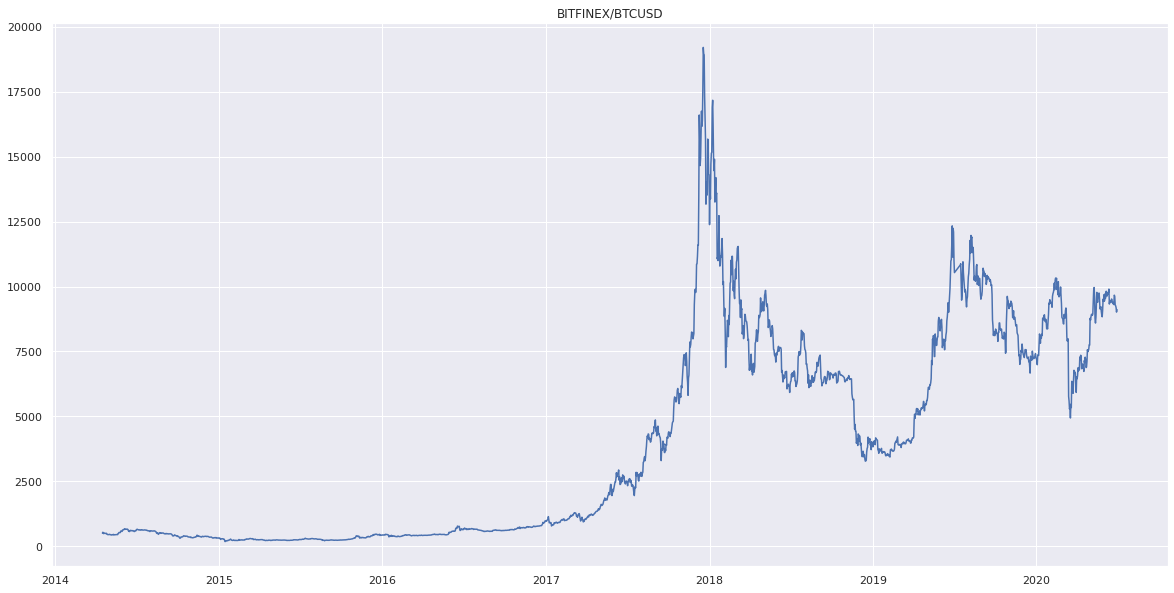

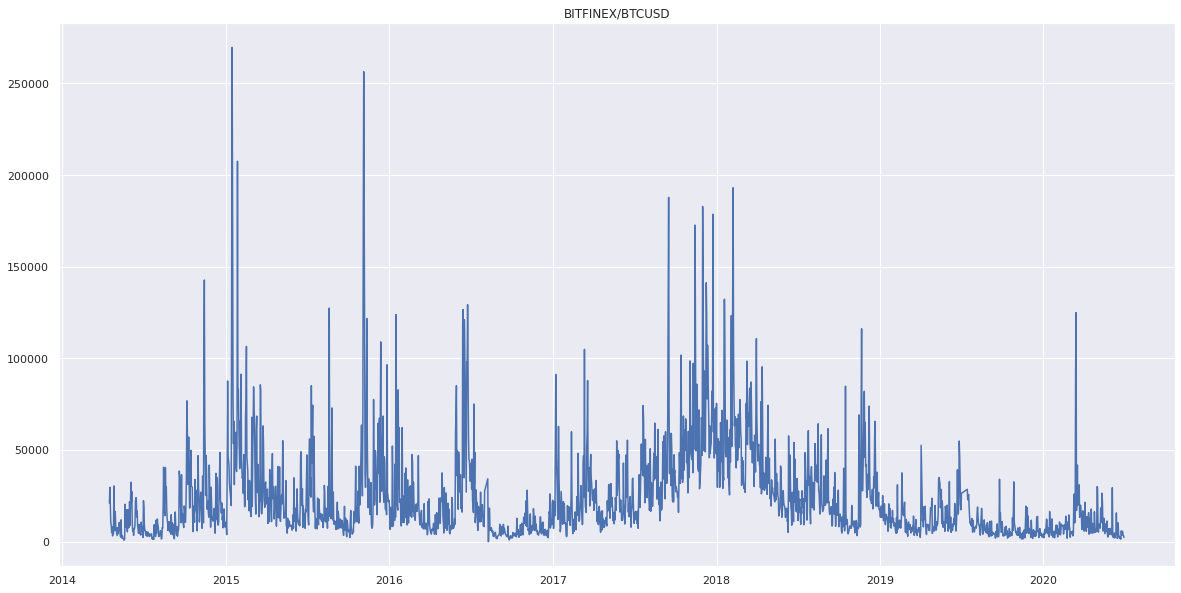

In [7]:
start_date_string = '2014-04-01'
asset = 'BITFINEX/BTCUSD'
column_price = 'Last'
column_high = 'High'
column_low = 'Low'
column_volume = 'Volume'

quandl.ApiConfig.api_key = jsnIEX['quandl_token']
dataset = quandl.get(asset, collapse = 'daily',
                     trim_start = start_date_string)
dataset = dataset.shift(1)
print(dataset.columns)

plt.figure(figsize=(20,10))
plt.plot(dataset[column_price])
plt.title(asset)
plt.show()
    
plt.figure(figsize=(20,10))
plt.plot(dataset[column_volume])
plt.title(asset)
plt.show()

### Let's generate the features and look at them

<Figure size 1440x720 with 0 Axes>

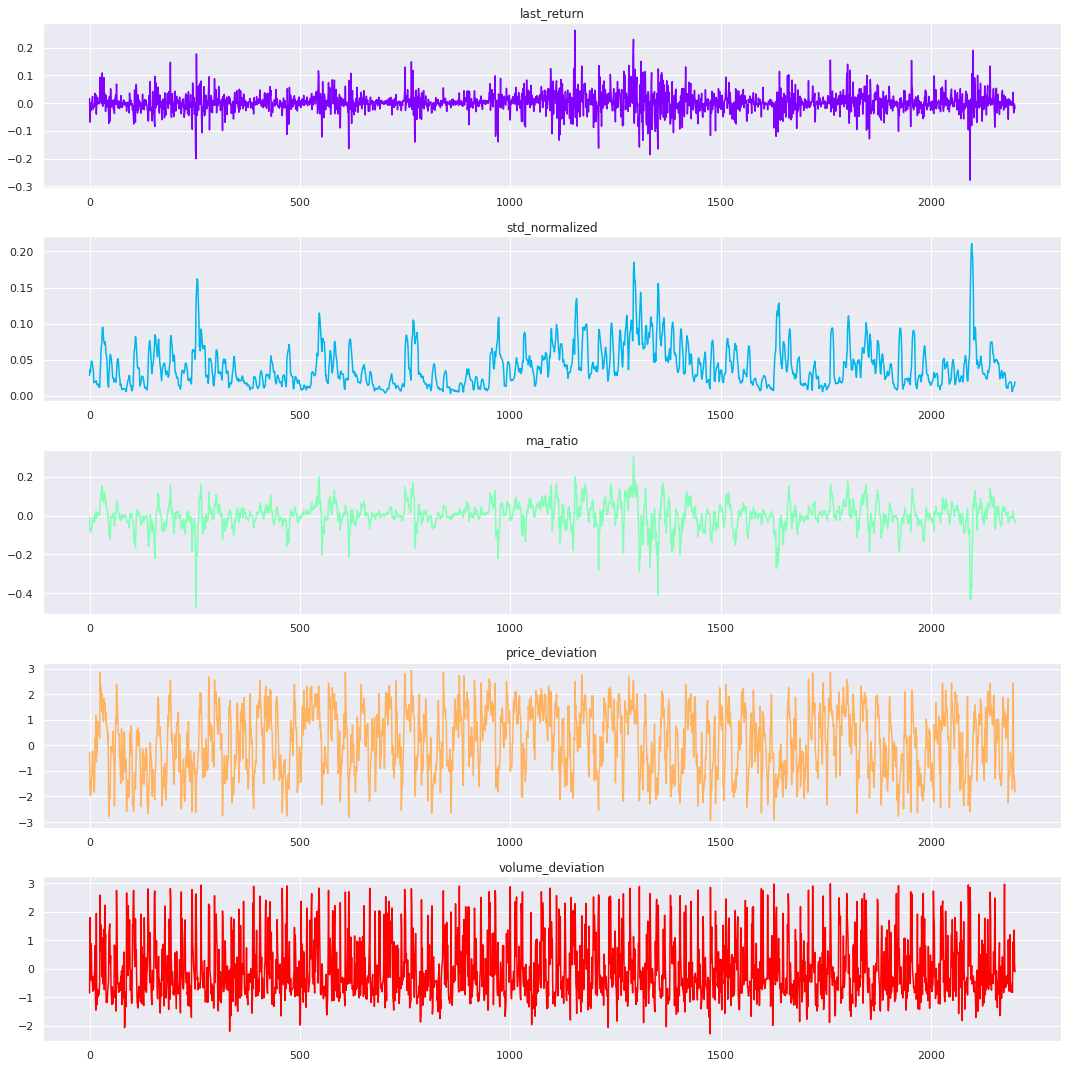

In [8]:
# Feature params
future_period = 1
std_period = 10
ma_period = 10
price_deviation_period = 10
volume_deviation_period = 10

# Create features
cols_features = ['last_return', 'std_normalized', 'ma_ratio', 'price_deviation', 'volume_deviation']
dataset['last_return'] = dataset[column_price].pct_change()
dataset['std_normalized'] = dataset[column_price].rolling(std_period).apply(std_normalized)
dataset['ma_ratio'] = dataset[column_price].rolling(ma_period).apply(ma_ratio)
dataset['price_deviation'] = dataset[column_price].rolling(price_deviation_period).apply(values_deviation)
dataset['volume_deviation'] = dataset[column_volume].rolling(volume_deviation_period).apply(values_deviation)

dataset["future_return"] = dataset[column_price].pct_change(future_period).shift(-future_period)

dataset = dataset.replace([np.inf, -np.inf], np.nan)
dataset = dataset.dropna()

# Split the data on sets
train_ind = int(np.where(dataset.index == '2018-01-01 00:00:00')[0])
train_set = dataset[cols_features].values[:train_ind]
test_set = dataset[cols_features].values[train_ind:]

# Plot features
plt.figure(figsize=(20,10))
fig, axs = plt.subplots(len(cols_features), 1, figsize = (15, 15))
colours = cm.rainbow(np.linspace(0, 1, len(cols_features)))
for i in range(0, len(cols_features)):
    axs[i].plot(dataset.reset_index()[cols_features[i]], color = colours[i])
    axs[i].set_title(cols_features[i])
    axs[i].grid(True)

plt.tight_layout()

### Modeling

In [9]:
model = get_best_hmm_model(X = train_set, max_states = 3, max_iter = 1000000)
print("Best model with {0} states ".format(str(model.n_components)))

Best model with 3 states 


### Lets look at state and the next market movement

<Figure size 1080x1080 with 0 Axes>

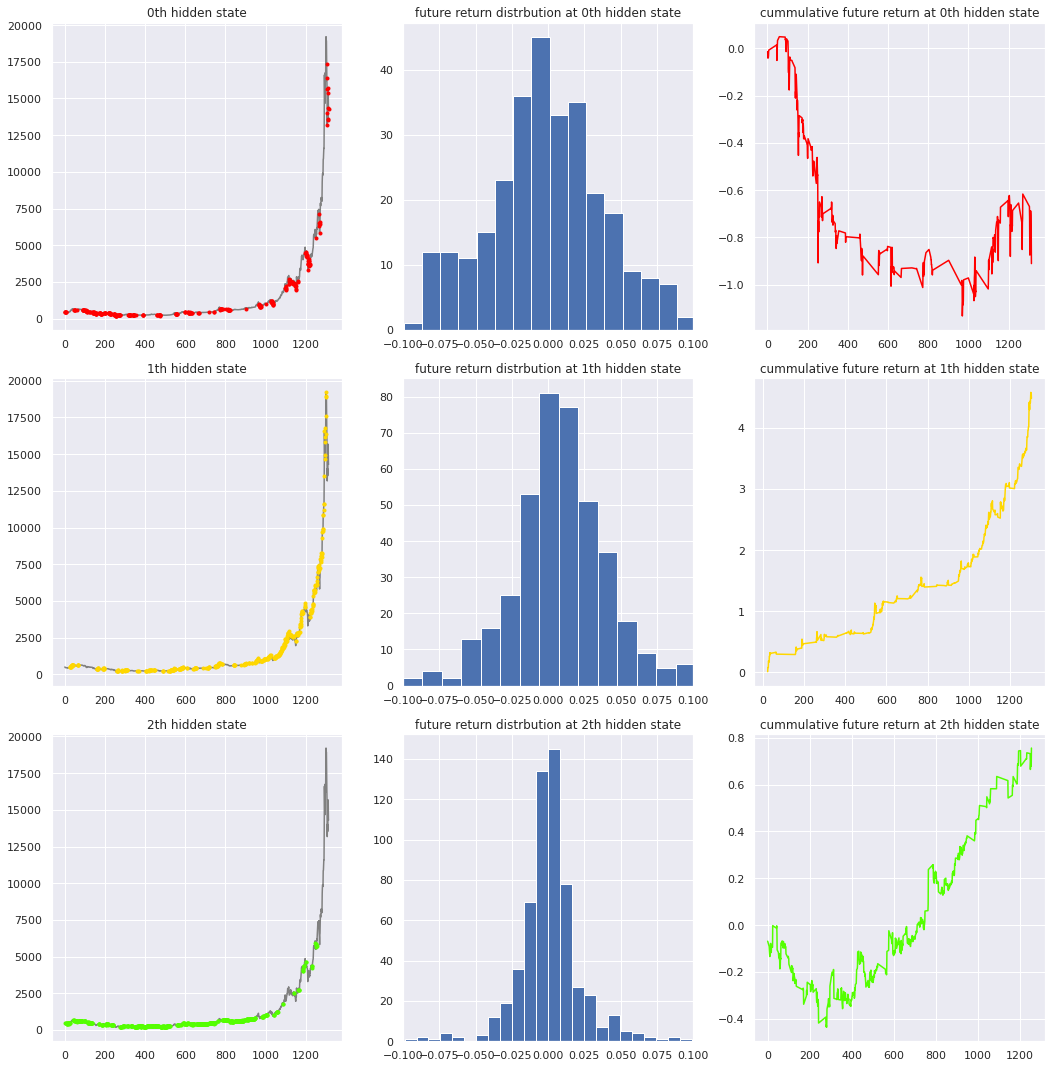

In [10]:
plot_hidden_states(model, dataset[:train_ind].reset_index(), train_set, column_price)

### Feature distribution depending on market state

<Figure size 1080x1080 with 0 Axes>

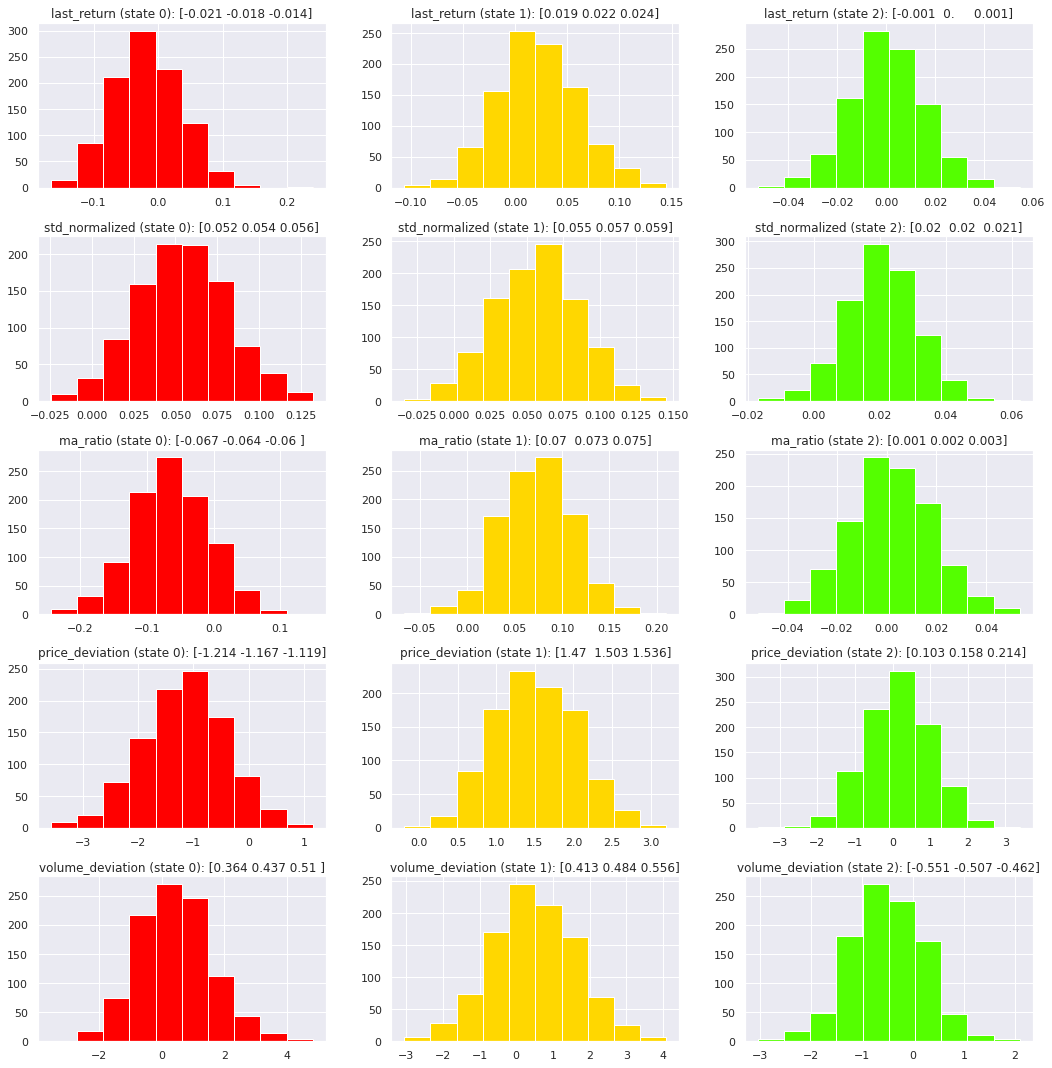

In [11]:
compare_hidden_states(hmm_model=model, cols_features=cols_features, conf_interval=0.95)

### Save our model

In [8]:
joblib.dump(model, '015quandl_' + asset.replace('/', '_') + '_final_model.pkl')

['quandl_BITFINEX_BTCUSD_final_model.pkl']